# Imports

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitz as fitz
from enum import Enum
import io as io

## Classes and Enums

In [44]:
# using as a value tracker

class BehaviorTitles(Enum):
	chatted_with_visitors = "Chatted with Visitors"
	chatted_with_staff = "Chatted with Staff"
	sat_on_bench = "Sat on a Bench"
	split_from_group = "Split from their Group"
	used_phone = "Used a Cell Phone"
	used_museum_guide = "Used the Museum Guide"
	used_headphones = "Used Headphones"

# Code

## Constants

In [45]:
# TODO: update all values accordingly
# relative file paths
visitor_xlsx_path: str = "../../assets/excel_files/observation_tables.xlsx"

# sheet name
main_sheet_name: str = "main data"

# export paths
observation_export_path: str = "../../assets/output_files/behavior_bar_chart.pdf"

## Loading XLSX

In [46]:
visitor_xlsx: pd.ExcelFile = pd.ExcelFile(visitor_xlsx_path)
visitor_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=main_sheet_name, index_col=0)

## Operations

### Support Functions

In [47]:
BEHAVIOR_COLS: list[str] = [
	"chatted_with_visitors",
	"chatted_with_staff",
	"sat_on_bench",
	"split_from_group",
	"used_phone",
	"used_museum_guide",
	"used_headphones"
]

ENUM_CLASSES: list[str] = [
	BehaviorTitles
]

In [48]:
def plot_data(df: pd.DataFrame, analysis_cols: list, enum_classes: list, export_path: str, show_chart: bool) -> None:
	plot_df: pd.DataFrame = df.copy()
	plot_df = plot_df[analysis_cols]

	fig: plt.Figure
	ax: plt.Axes
	fig, ax = plt.subplots(figsize=(10, 6))

	master_map: dict[str, str] = {}
	for enum_cls in enum_classes:
		for member in enum_cls:
			master_map[member.name] = str(member.value)
	plot_df = plot_df.rename(columns=master_map)

	percentage_data: pd.Series = plot_df.mean() * 100
	percentage_data = percentage_data.sort_values()

	bars: plt.BarContainer = ax.barh(
		percentage_data.index,
		percentage_data.values,
		color='lightgreen',
		edgecolor='black'
	)
	
	ax.set_title('Percent of Visitors that Displayed Notable Behaviors', fontsize=14)
	ax.set_xlabel('% of Visitors', fontsize=12)
	ax.set_xlim(0, 100)
	ax.grid(axis='x', linestyle='--', alpha=0.7)

	for bar in bars:
		width: float = bar.get_width()
		ax.text(
			width + 1,
			bar.get_y() + bar.get_height() / 2,
			f'{width:.1f}%',
			va='center',
			fontsize=10
		)

	plt.tight_layout()
	if show_chart:
		plt.show()
	fig.savefig(export_path, format="png", dpi=150)

### Execution

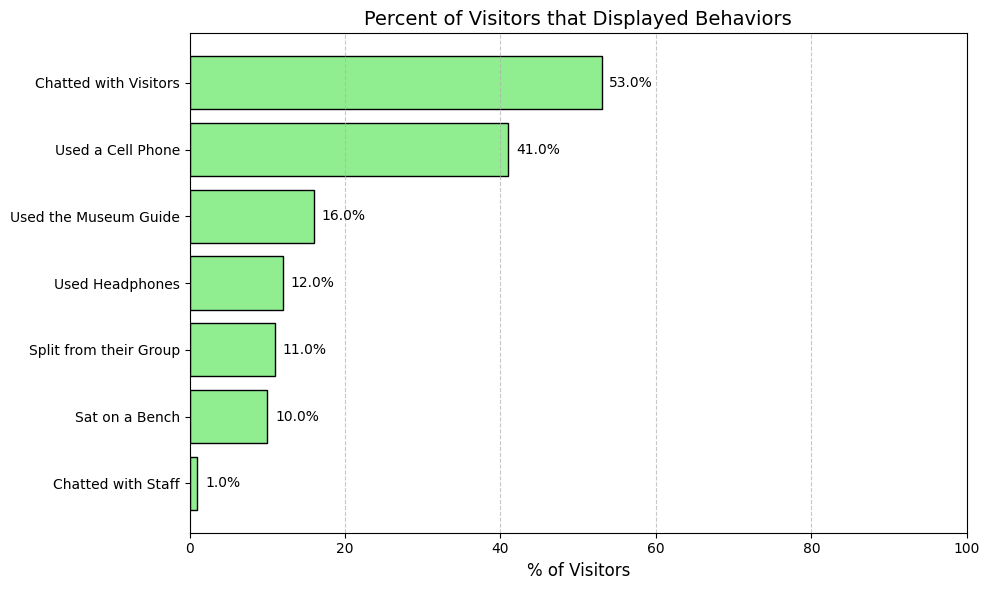

In [49]:
plot_data(visitor_df, BEHAVIOR_COLS, ENUM_CLASSES, observation_export_path, False)